In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
#from matplotlib.pyplot import cm
#import matplotlib.pyplot as plt

from numpy import average
from matplotlib import pylab as plt
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)
from sklearn.metrics import accuracy_score, make_scorer, multilabel_confusion_matrix, confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score 
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, GridSearchCV

#from multiscorer import MultiScorer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import f1_score, classification_report , recall_score    
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import label_binarize

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_score, recall_score, precision_recall_curve,f1_score, 
precision_recall_fscore_support, roc_curve)

random_state = 42

%matplotlib inline


Using TensorFlow backend.


# Import Data

In [2]:
wines_df = pd.read_pickle('./data/wines_df.pkl')

In [3]:
wines_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,good_quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white,1.0
1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white,1.0
2,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white,1.0
3,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white,1.0
4,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white,1.0


In [4]:
wines_df.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,good_quality
6492,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,red,1.0
6493,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,red,1.0
6494,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,red,1.0
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,red,1.0
6496,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,6,red,1.0


# EDA

In [5]:
wines_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 6496
Data columns (total 14 columns):
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int64
type                    6497 non-null object
good_quality            6497 non-null float64
dtypes: float64(12), int64(1), object(1)
memory usage: 761.4+ KB


In [6]:
wines_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good_quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.992612
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.261333
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,1.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,2.000000


In [7]:
wines_df.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good_quality
fixed acidity,1.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452,-0.076743,-0.048783
volatile acidity,0.219008,1.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640,-0.265699,-0.144803
citric acid,0.324436,-0.377981,1.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493,0.085532,0.057376
residual sugar,-0.111981,-0.196011,0.142451,1.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415,-0.036980,0.033351
chlorides,0.298195,0.377124,0.038998,-0.128940,1.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916,-0.200666,-0.075989
free sulfur dioxide,-0.282735,-0.352557,0.133126,0.402871,-0.195045,1.000000,0.720934,0.025717,-0.145854,-0.188457,-0.179838,0.055463,0.088386
total sulfur dioxide,-0.329054,-0.414476,0.195242,0.495482,-0.279630,0.720934,1.000000,0.032395,-0.238413,-0.275727,-0.265740,-0.041385,0.029329
density,0.458910,0.271296,0.096154,0.552517,0.362615,0.025717,0.032395,1.000000,0.011686,0.259478,-0.686745,-0.305858,-0.097890
pH,-0.252700,0.261454,-0.329808,-0.267320,0.044708,-0.145854,-0.238413,0.011686,1.000000,0.192123,0.121248,0.019506,-0.009716
sulphates,0.299568,0.225984,0.056197,-0.185927,0.395593,-0.188457,-0.275727,0.259478,0.192123,1.000000,-0.003029,0.038485,0.009227


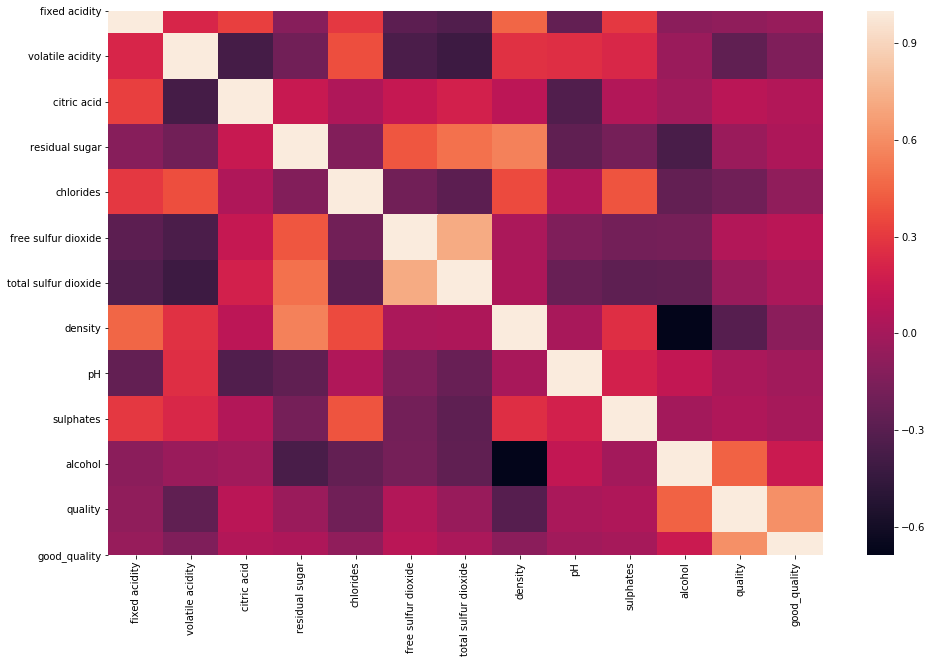

In [8]:
cor = wines_df.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor)
plt.show()

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


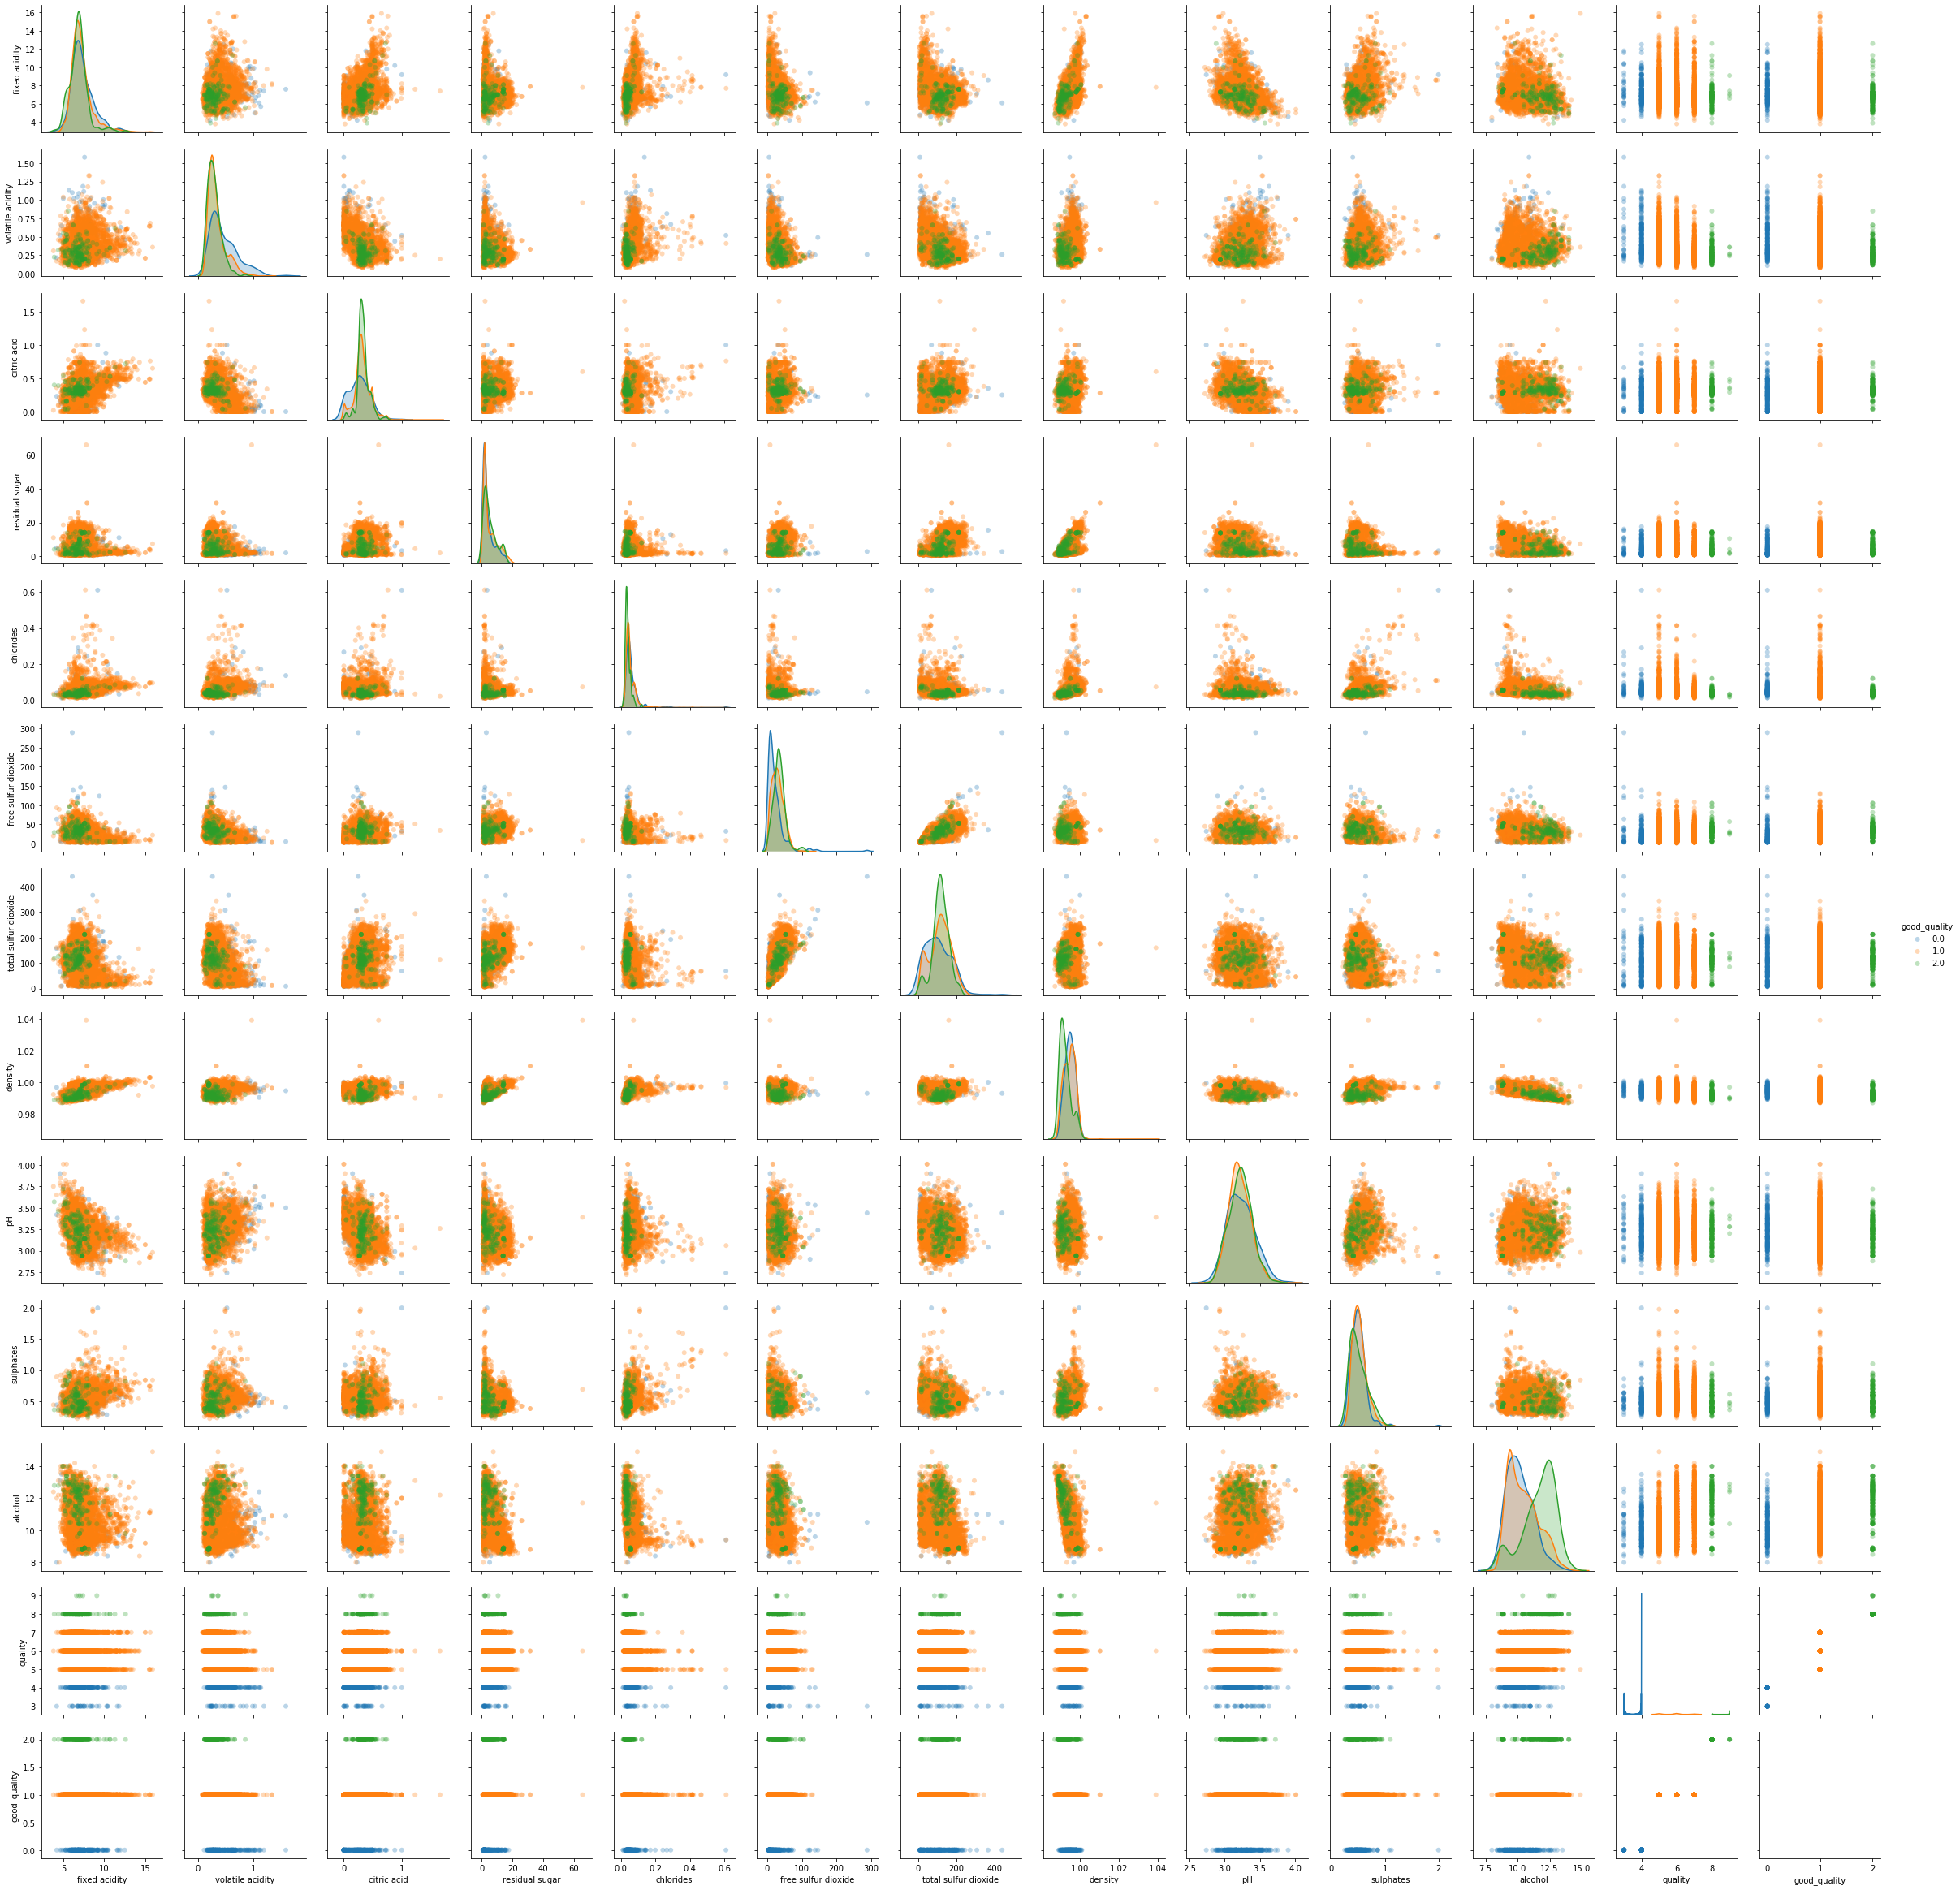

In [9]:
sns.pairplot(wines_df, hue='good_quality', plot_kws=dict(alpha=.3, edgecolor='none'));

### Class distribution

In [10]:
label_count = wines_df.groupby('good_quality', as_index = False).count()

class_name = list(['Poor', 'Normal', 'Excellent'])
count = list(label_count['volatile acidity'])

count

[246, 6053, 198]

In [11]:
colors2 = ["#D5D3D3", "#D18D8A","#B82629"]
# Set custom color palette
sns.set_palette(sns.color_palette(colors2))

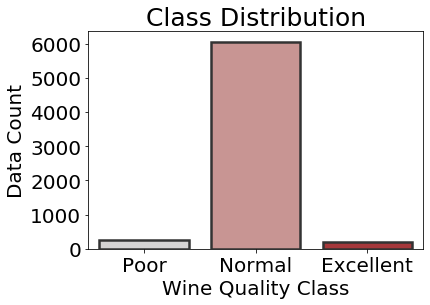

In [12]:
index = np.arange(len(class_name))
sns.barplot(x=class_name, y=count, linewidth=2.5, errcolor=".2", edgecolor=".2")
plt.xlabel('Wine Quality Class', fontsize=20)
plt.yticks(fontsize = 20)
plt.ylabel('Data Count', fontsize=20)
plt.xticks(index, class_name, fontsize=20)
plt.title('Class Distribution', fontsize = 25)
#plt.show()
plt.savefig('class_distri_2.svg', format='svg', bbox_inches='tight')

# Split into Test and Train Sets

In [13]:
X = wines_df.iloc[:, :-3]
y = wines_df['good_quality']
X.head()


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


kf = StratifiedKFold(n_splits=3, random_state=42)

# Logistic Regression

In [14]:
#multi_class = 'multinomial' for combining all scores into one
#no multiclass for getting scores based on class
#macro averages them by class

def log_reg (C_list, X_train, y_train, kf):
    logregcv = LogisticRegressionCV(Cs=C_list, cv=kf, random_state=random_state, scoring = 'f1_macro')#, multi_class = 'multinomial''roc_auc', multi_class = 'multinomial'
    logregcv.fit(X_train,y_train)
    print(f'Classes: {logregcv.classes_}')
    print(f'All C values tried: {logregcv.Cs_}') 
    print(f'Best C value from choices: {logregcv.C_}') 
    print(f'Y intercepts: {logregcv.intercept_}')
    print(f'Feature coefficients: {logregcv.coef_}')
    return(logregcv)
 

### First log reg iteration

In [15]:
C = [100000,200000,300000]
lr = log_reg(C, X_train,y_train, kf)

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/sit

Classes: [0. 1. 2.]
All C values tried: [100000 200000 300000]
Best C value from choices: [100000 100000 100000]
Y intercepts: [-0.37956609  1.95421116 -4.55408993]
Feature coefficients: [[ 2.23176141e-02  3.54339078e+00 -3.61950697e-01 -8.01276299e-02
  -1.52230657e+00 -3.63211276e-02  1.01127195e-02 -4.72039145e-01
   1.53303735e-01 -2.65005162e+00 -2.53781467e-01]
 [ 3.02581489e-02 -2.42384706e+00 -1.37531617e-01  2.10336096e-02
   1.01067366e+00  6.24489085e-03 -3.30704233e-03  2.00167901e+00
   4.07214125e-01  1.52753438e+00 -2.56462237e-01]
 [-7.19543421e-02 -2.17861349e+00 -4.49238240e-01  7.01898619e-02
  -9.32174021e-01  1.89344635e-02 -3.14908685e-03 -4.54471948e+00
  -8.98136689e-01  1.57994165e-01  8.34312727e-01]]


/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site-pack

In [16]:
lr.scores_

{0.0: array([[0.49029982, 0.49029982, 0.49029982],
        [0.50535811, 0.50535811, 0.50535811],
        [0.49013255, 0.49013255, 0.49013255]]),
 1.0: array([[0.48192411, 0.48192411, 0.48192411],
        [0.49046608, 0.48205742, 0.49046608],
        [0.48220162, 0.48220162, 0.48220162]]),
 2.0: array([[0.49194257, 0.49194257, 0.49179367],
        [0.49178404, 0.49178404, 0.49178404],
        [0.49207746, 0.49207746, 0.49207746]])}

In [17]:
lr.get_params

<bound method BaseEstimator.get_params of LogisticRegressionCV(Cs=[100000, 200000, 300000], class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='warn',
                     n_jobs=None, penalty='l2', random_state=42, refit=True,
                     scoring='f1_macro', solver='lbfgs', tol=0.0001, verbose=0)>

### Second log reg iteration

In [18]:
C = [1000, 10000, 100000]
lr = log_reg(C, X_train, y_train, kf)

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/sit

Classes: [0. 1. 2.]
All C values tried: [  1000  10000 100000]
Best C value from choices: [1000 1000 1000]
Y intercepts: [-0.34547597  2.56579114 -6.3680932 ]
Feature coefficients: [[ 1.86234163e-02  3.40049435e+00 -2.07525607e-01 -7.93583895e-02
  -1.42266329e+00 -3.63177879e-02  9.63049923e-03 -4.30396612e-01
   2.07320166e-01 -2.59767765e+00 -2.72056971e-01]
 [ 1.23417459e-02 -2.40789085e+00 -3.22513627e-02  1.93694082e-02
   1.46426770e+00  6.18690072e-03 -3.88101142e-03  2.63426079e+00
   9.48938520e-02  1.49413035e+00 -2.63271458e-01]
 [-2.09900987e-02 -2.60174832e+00  1.81757445e-01  7.66940411e-02
  -1.38434472e+00  1.88997241e-02 -2.49630229e-03 -6.36973435e+00
  -8.28851253e-02  2.02956990e-01  8.73623237e-01]]


/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logisti

In [19]:
lr.scores_

{0.0: array([[0.49029982, 0.49029982, 0.49029982],
        [0.50535811, 0.50498857, 0.50535811],
        [0.49013255, 0.49013255, 0.49013255]]),
 1.0: array([[0.48192411, 0.48192411, 0.48192411],
        [0.49046608, 0.49046608, 0.49046608],
        [0.48220162, 0.48220162, 0.48220162]]),
 2.0: array([[0.49194257, 0.49179367, 0.49179367],
        [0.49178404, 0.49178404, 0.49178404],
        [0.49207746, 0.49207746, 0.49207746]])}

### Third log reg iteration

In [20]:
C = [105555, 105553, 105554]
lr = log_reg(C, X_train, y_train,kf)

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classi

Classes: [0. 1. 2.]
All C values tried: [105555 105553 105554]
Best C value from choices: [105555 105555 105555]
Y intercepts: [-0.34218167  2.51076192 -5.33500189]
Feature coefficients: [[ 1.61880759e-02  3.44870018e+00 -8.35329124e-02 -8.00505221e-02
  -1.46978232e+00 -3.62914729e-02  9.49467803e-03 -4.30467550e-01
   2.58360802e-01 -2.82591280e+00 -2.78975777e-01]
 [ 1.80821004e-02 -2.44298529e+00 -1.40980537e-02  1.98047373e-02
   1.41663845e+00  5.93736197e-03 -3.92806701e-03  2.58118435e+00
   1.62728485e-01  1.34585659e+00 -2.68334825e-01]
 [-2.35894771e-02 -2.34086253e+00 -5.55577471e-01  7.37670203e-02
  -1.13056849e+00  1.89871515e-02 -3.00427876e-03 -5.33244133e+00
  -4.97378460e-01 -2.14121205e-01  8.50089448e-01]]


/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [21]:
lr.scores_


{0.0: array([[0.49029982, 0.49029982, 0.49029982],
        [0.50535811, 0.50535811, 0.50498857],
        [0.49013255, 0.49013255, 0.49013255]]),
 1.0: array([[0.48192411, 0.48192411, 0.48192411],
        [0.49046608, 0.49046608, 0.49046608],
        [0.48220162, 0.48220162, 0.48220162]]),
 2.0: array([[0.49179367, 0.49179367, 0.49179367],
        [0.49178404, 0.49178404, 0.49178404],
        [0.49207746, 0.49207746, 0.49207746]])}

# Random Forest

In [22]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import cross_validate, KFold


from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report, roc_auc_score, roc_curve     
from sklearn.model_selection import cross_val_score
from numpy import average

In [23]:
wines_df.info

<bound method DataFrame.info of       fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.0             0.270         0.36            20.7      0.045   
1               7.0             0.270         0.36            20.7      0.045   
2               6.3             0.300         0.34             1.6      0.049   
3               6.3             0.300         0.34             1.6      0.049   
4               8.1             0.280         0.40             6.9      0.050   
...             ...               ...          ...             ...        ...   
6492            6.8             0.620         0.08             1.9      0.068   
6493            6.2             0.600         0.08             2.0      0.090   
6494            5.9             0.550         0.10             2.2      0.062   
6495            5.9             0.645         0.12             2.0      0.075   
6496            6.0             0.310         0.47             3.6      0.067

In [24]:
# Instantiate model with 50 decision trees
rf = RandomForestClassifier(n_estimators = 50, random_state = 42)
y_score = cross_val_score(rf, X_train, y_train, cv=kf, scoring= 'f1_macro')

y_score

array([0.52974679, 0.56314633, 0.50217153])

In [25]:
# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
y_score = cross_val_score(rf, X_train, y_train, cv=kf, scoring= 'f1_macro')
y_score

array([0.53858175, 0.5546773 , 0.51360647])

In [26]:
# Instantiate model with 150 decision trees
rf = RandomForestClassifier(n_estimators = 150, random_state = 42)
y_score = cross_val_score(rf, X_train, y_train, cv=kf, scoring= 'f1_macro')
y_score

array([0.53251307, 0.5546773 , 0.51360641])

In [27]:
# Instantiate model with 200 decision trees
rf = RandomForestClassifier(n_estimators = 200, random_state = 42)
y_score = cross_val_score(rf, X_train, y_train, cv=kf, scoring= 'f1_macro')
y_score

array([0.53251307, 0.545217  , 0.50546113])

In [28]:
# Instantiate model with 250 decision trees
rf = RandomForestClassifier(n_estimators = 250, random_state = 42)
y_score = cross_val_score(rf, X_train, y_train, cv=kf, scoring= 'f1_macro')
y_score

array([0.53251307, 0.545217  , 0.50546113])

In [29]:
# Instantiate model with 300 decision trees
rf = RandomForestClassifier(n_estimators = 300, random_state = 42)
y_score = cross_val_score(rf, X_train, y_train, cv=kf, scoring= 'f1_macro')
y_score

array([0.53251307, 0.55381281, 0.52071262])

# Exploring RF deeper because higher F1 scores across all classes

In [30]:
def model_confusion_mat(model, X, y, T, sampler):
    X = np.array(X)
    y = np.array(y)
    T = np.array(T)

    n_splits = 3
    folds = list(StratifiedKFold(n_splits=n_splits, shuffle=True, 
                                 random_state = random_state).split(X, y))

    train_pred = np.zeros((X.shape[0], 1))
    test_pred = np.zeros((T.shape[0], 1* n_splits))
    f1_scores = np.zeros((1, n_splits))
    recall_scores = np.zeros((1, n_splits))
    precision_scores = np.zeros((1, n_splits))

    test_col = 0
    
    for i, clf in enumerate(model):

        for j, (train_idx, valid_idx) in enumerate(folds):
            
            if sampler:
                X_train, Y_train = sampler.fit_resample(X[train_idx],  y[train_idx])
            else:
                X_train =X[train_idx]
                Y_train = y[train_idx]
            X_valid = X[valid_idx]
            Y_valid = y[valid_idx]

            clf.fit(X_train, Y_train)

            valid_pred = clf.predict(X_valid)
            recall  = recall_score(Y_valid, valid_pred, average='macro')
            f1 = f1_score(Y_valid, valid_pred, average='macro')
            precision = precision_score(Y_valid, valid_pred, average='macro')

            recall_scores[i][j] = recall
            precision_scores[i][j] = precision
            f1_scores[i][j] = f1

            train_pred[valid_idx, i] = valid_pred
            test_pred[:, test_col] = clf.predict(T)
            test_col += 1

            print(f"Model- {i} and CV- {j} recall: {recall}, precision: {precision}, f1_score: {f1}")

    return train_pred, test_pred, recall_scores, f1_scores

In [31]:
X_to_split, X_test, y_to_split, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify = y)

X_train, X_val, y_train, y_val = train_test_split(
    X_to_split, y_to_split, test_size=0.2, random_state=42, stratify = y_to_split)

### Baseline

In [32]:
rf = RandomForestClassifier(n_estimators = 300, random_state = random_state)
train_pred, test_pred, recall_scores, f1_scores = model_confusion_mat([rf],X_train, y_train, X_val, None)

Model- 0 and CV- 0 recall: 0.41027661959950806, precision: 0.7238083677267945, f1_score: 0.4496116996116996
Model- 0 and CV- 1 recall: 0.4225970381722102, precision: 0.789329162321863, f1_score: 0.47341556690319875
Model- 0 and CV- 2 recall: 0.3827609476331397, precision: 0.6772756721736313, f1_score: 0.411146187589857


In [33]:
print('1. The F-1 score of the model {}\n'.format(f1_score(y_train, train_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(y_train, train_pred, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(y_train, train_pred)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(y_train, train_pred)))

1. The F-1 score of the model 0.4459468009961962

2. The recall score of the model 0.4051834669793469

3. Classification report 
               precision    recall  f1-score   support

         0.0       0.41      0.04      0.08       158
         1.0       0.94      1.00      0.97      3873
         2.0       0.88      0.17      0.29       126

    accuracy                           0.94      4157
   macro avg       0.74      0.41      0.45      4157
weighted avg       0.92      0.94      0.91      4157
 

4. Confusion matrix 
 [[   7  151    0]
 [  10 3860    3]
 [   0  104   22]] 



In [34]:
cm_baseline = confusion_matrix(y_train, train_pred)

### Random Oversampling to remedy imbalance:

In [35]:
rf = RandomForestClassifier(n_estimators = 300, random_state = random_state)
ros = RandomOverSampler(random_state= random_state)
train_pred, test_pred, recall_scores, f1_scores = model_confusion_mat([rf],X_train, y_train, X_val, ros)

Model- 0 and CV- 0 recall: 0.4095020262610108, precision: 0.6545324100068626, f1_score: 0.4429297809793864
Model- 0 and CV- 1 recall: 0.4437265711033304, precision: 0.723821557644008, f1_score: 0.49624396760186923
Model- 0 and CV- 2 recall: 0.38454539693889034, precision: 0.6872117018693857, f1_score: 0.4122980122980123


In [36]:
print('1. The F-1 score of the model {}\n'.format(f1_score(y_train, train_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(y_train, train_pred, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(y_train, train_pred)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(y_train, train_pred)))

1. The F-1 score of the model 0.45235154013895357

2. The recall score of the model 0.4126035793568566

3. Classification report 
               precision    recall  f1-score   support

         0.0       0.44      0.04      0.08       158
         1.0       0.94      1.00      0.97      3873
         2.0       0.71      0.20      0.31       126

    accuracy                           0.93      4157
   macro avg       0.70      0.41      0.45      4157
weighted avg       0.91      0.93      0.91      4157
 

4. Confusion matrix 
 [[   7  151    0]
 [   9 3854   10]
 [   0  101   25]] 



### SMOTE  to remedy imbalance:

In [37]:
rf = RandomForestClassifier(n_estimators = 300, random_state = random_state)
smote = SMOTE(random_state=random_state)
train_pred, test_pred, recall_scores, f1_scores = model_confusion_mat([rf], X_train, y_train, X_val, smote)

Model- 0 and CV- 0 recall: 0.4977056819054393, precision: 0.45264598172964704, f1_score: 0.4702426065903232
Model- 0 and CV- 1 recall: 0.5267717227730674, precision: 0.46519734946701236, f1_score: 0.48867932557648364
Model- 0 and CV- 2 recall: 0.50174449012559, precision: 0.48526129550929165, f1_score: 0.4906151777044994


In [38]:
print('1. The F-1 score of the model {}\n'.format(f1_score(y_train, train_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(y_train, train_pred, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(y_train, train_pred)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(y_train, train_pred)))

1. The F-1 score of the model 0.48292593983909193

2. The recall score of the model 0.5088008505533925

3. Classification report 
               precision    recall  f1-score   support

         0.0       0.22      0.26      0.24       158
         1.0       0.95      0.93      0.94      3873
         2.0       0.23      0.34      0.27       126

    accuracy                           0.88      4157
   macro avg       0.47      0.51      0.48      4157
weighted avg       0.90      0.88      0.89      4157
 

4. Confusion matrix 
 [[  41  116    1]
 [ 144 3585  144]
 [   1   82   43]] 



### ADASYN  to remedy imbalance:

In [39]:
rf = RandomForestClassifier(n_estimators = 250, random_state = 42)
adasyn = ADASYN(random_state=random_state)
train_pred, test_pred, recall_scores, f1_scores = model_confusion_mat([rf], X_train, y_train, X_val, adasyn)

Model- 0 and CV- 0 recall: 0.5206425992930531, precision: 0.46787104838950877, f1_score: 0.48851360862726384
Model- 0 and CV- 1 recall: 0.5320282398311716, precision: 0.4669586301850066, f1_score: 0.49142201539748237
Model- 0 and CV- 2 recall: 0.5022608856845882, precision: 0.48872020748557876, f1_score: 0.4926903337582949


In [40]:
print('1. The F-1 score of the model {}\n'.format(f1_score(y_train, train_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(y_train, train_pred, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(y_train, train_pred)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(y_train, train_pred)))

1. The F-1 score of the model 0.49063735469461145

2. The recall score of the model 0.518397331053598

3. Classification report 
               precision    recall  f1-score   support

         0.0       0.22      0.27      0.24       158
         1.0       0.95      0.93      0.94      3873
         2.0       0.24      0.36      0.29       126

    accuracy                           0.88      4157
   macro avg       0.47      0.52      0.49      4157
weighted avg       0.90      0.88      0.89      4157
 

4. Confusion matrix 
 [[  43  114    1]
 [ 149 3586  138]
 [   2   79   45]] 



### Class weights to remedy imbalance:

In [41]:
def model_confusion_matrix_pred_probas(models, X, y, T, sampler):
    X = np.array(X)
    y = np.array(y)
    T = np.array(T)
    no_class = len(np.unique(y))

    n_splits = 3
    
    folds = list(StratifiedKFold(n_splits=n_splits, shuffle=True, 
                                 random_state = random_state).split(X, y))

    train_proba = np.zeros((X.shape[0], no_class))
    test_proba = np.zeros((T.shape[0], no_class))

    train_pred = np.zeros((X.shape[0], len(models)))
    test_pred = np.zeros((T.shape[0], len(models)* n_splits))
    f1_scores = np.zeros((len(models), n_splits))
    recall_scores = np.zeros((len(models),n_splits))

    test_col = 0
    for i, clf in enumerate(models):

        for j, (train_idx, valid_idx) in enumerate(folds):

            if sampler:
                X_train, Y_train = sampler.fit_resample(X[train_idx],  y[train_idx])
            else:
                X_train = X[train_idx]
                Y_train = y[train_idx]
            X_valid = X[valid_idx]
            Y_valid = y[valid_idx]

            clf.fit(X_train, Y_train)

            valid_pred = clf.predict(X_valid)
            recall  = recall_score(Y_valid, valid_pred, average='macro')
            f1 = f1_score(Y_valid, valid_pred, average='macro')

            recall_scores[i][j] = recall
            f1_scores[i][j] = f1

            train_pred[valid_idx, i] = valid_pred
            test_pred[:, test_col] = clf.predict(T)
            test_col += 1

            ## Probabilities
            valid_proba = clf.predict_proba(X_valid)
            train_proba[valid_idx, :] = valid_proba
            test_proba  += clf.predict_proba(T)

            print( f"Model- {i} and CV- {j} recall: {recall}, f1_score: {f1}")

        #avg across the folds
        test_proba /= n_splits

    return train_proba, test_proba, train_pred, test_pred

In [42]:
total_ones = len(wines_df[wines_df['good_quality'] == 1])

In [43]:
total_zeros = len(wines_df[wines_df['good_quality'] == 0]) 
total_ones / total_zeros 

24.60569105691057

In [44]:
total_twos = len(wines_df[wines_df['good_quality'] == 2])
total_ones / total_twos

30.57070707070707

In [45]:
class_weight = dict({0:100, 1:1.9, 2:31})

In [46]:
rf = RandomForestClassifier(random_state = random_state, class_weight= class_weight) 
train_proba, test_proba, train_pred, test_pred = model_confusion_matrix_pred_probas([rf], X_train, y_train, X_val, None)

Model- 0 and CV- 0 recall: 0.41388593689720504, f1_score: 0.4587587638305796
Model- 0 and CV- 1 recall: 0.4135297260342932, f1_score: 0.4630084079236621
Model- 0 and CV- 2 recall: 0.37045683037162513, f1_score: 0.3903521368339597


/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [47]:
print('1. The F-1 score of the model {}\n'.format(f1_score(y_train, train_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(y_train, train_pred, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(y_train, train_pred)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(y_train, train_pred)))

1. The F-1 score of the model 0.4383688804287192

2. The recall score of the model 0.39935666368418915

3. Classification report 
               precision    recall  f1-score   support

         0.0       0.42      0.05      0.09       158
         1.0       0.94      1.00      0.97      3873
         2.0       0.90      0.15      0.26       126

    accuracy                           0.94      4157
   macro avg       0.75      0.40      0.44      4157
weighted avg       0.92      0.94      0.91      4157
 

4. Confusion matrix 
 [[   8  150    0]
 [  11 3860    2]
 [   0  107   19]] 



##  Tuning Hyperparameters

### GridSearchCV for best model parameters

In [48]:
cv = StratifiedKFold(n_splits = 3, shuffle=True, random_state = random_state)

rdf = RandomForestClassifier(random_state = random_state) 
scoring = {'Recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score),
           'Precision': make_scorer(recall_score)
          }

params = {'max_depth': [12, 15, 20, 24], 
              'min_samples_split': [10, 15, 20],
              'min_samples_leaf' : [4, 6, 8],
              'n_estimators' : [300, 400, 500]
             }

grid_clf = GridSearchCV(estimator = rdf, param_grid = params, cv = cv, n_jobs=-1, verbose=4)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  1.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=Fa

In [49]:
print(grid_clf.best_estimator_)
print(grid_clf.best_params_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
{'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}


In [50]:
rdf = grid_clf.best_estimator_

In [51]:
rdf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### ADASYN with best parameters

In [52]:
adsayn = ADASYN(random_state=random_state)
train_pred, test_pred, recall_scores, f1_scores = model_confusion_mat([rdf], X_train, y_train, X_val, smote)

Model- 0 and CV- 0 recall: 0.5832139197601104, precision: 0.4340889920864712, f1_score: 0.46320809507885063
Model- 0 and CV- 1 recall: 0.5604262838380022, precision: 0.4173308726031267, f1_score: 0.4405588968948702
Model- 0 and CV- 2 recall: 0.5190108755174596, precision: 0.42928002889688716, f1_score: 0.4515833704235466


In [53]:
print('1. The F-1 score of the model {}\n'.format(f1_score(y_train, train_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(y_train, train_pred, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(y_train, train_pred)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(y_train, train_pred)))

1. The F-1 score of the model 0.4520492512533651

2. The recall score of the model 0.5543144994213246

3. Classification report 
               precision    recall  f1-score   support

         0.0       0.19      0.37      0.25       158
         1.0       0.95      0.85      0.90      3873
         2.0       0.14      0.44      0.21       126

    accuracy                           0.82      4157
   macro avg       0.43      0.55      0.45      4157
weighted avg       0.90      0.82      0.85      4157
 

4. Confusion matrix 
 [[  59   96    3]
 [ 252 3273  348]
 [   2   68   56]] 



### Class weights set with best parameters

In [54]:
rdf2 = RandomForestClassifier(bootstrap=True, class_weight=class_weight, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [55]:
train_proba, test_proba, train_pred, test_pred = model_confusion_matrix_pred_probas([rdf2], X_train, y_train, X_val, None)

Model- 0 and CV- 0 recall: 0.4624910309329291, f1_score: 0.5146820262586905
Model- 0 and CV- 1 recall: 0.4820713771870546, f1_score: 0.5270668053162154
Model- 0 and CV- 2 recall: 0.4106810652124362, f1_score: 0.44322362553513955


In [56]:
print('1. The F-1 score of the model {}\n'.format(f1_score(y_train, train_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(y_train, train_pred, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(y_train, train_pred)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(y_train, train_pred)))

1. The F-1 score of the model 0.4979304993252361

2. The recall score of the model 0.45181008471657463

3. Classification report 
               precision    recall  f1-score   support

         0.0       0.32      0.18      0.23       158
         1.0       0.94      0.98      0.96      3873
         2.0       0.71      0.19      0.30       126

    accuracy                           0.93      4157
   macro avg       0.65      0.45      0.50      4157
weighted avg       0.91      0.93      0.91      4157
 

4. Confusion matrix 
 [[  29  129    0]
 [  62 3801   10]
 [   1  101   24]] 



### Probability distribution by class

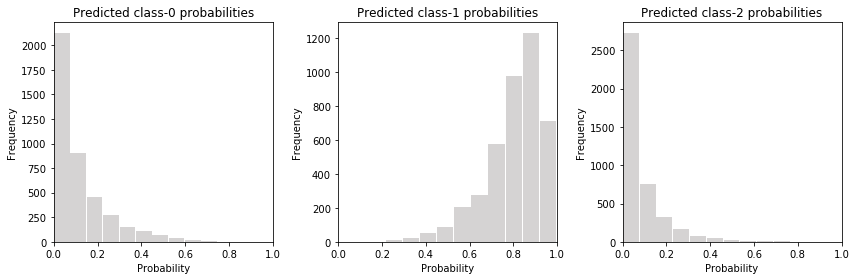

In [57]:
# histogram of predicted probabilities to see where data is bunched and that's where to make the threshold cutoff
plt.figure(figsize=(12, 4))
nclasses = 3
for i in range(nclasses):
    
    plt.subplot(1, 3, i+1)
    plt.hist(train_proba[:, i], bins=10, histtype='bar', rwidth=0.95)
    plt.xlim(0,1)
    plt.title('Predicted class-{} probabilities'.format(i))
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Under-Predict and Over-Predict normal class(class 1)

In [58]:
def re_predict(data, threshods):

    argmax = np.argmax(data)
    
    if argmax == 0: 
        return (argmax)
    
    elif argmax == 1:
        if data[argmax] >= threshods[argmax] : 
            return (argmax)
#         else:
#             return (argmax - 1)
        else:
            # case A : if class_0_prob >= threshold and class_2_prob < threshold then pick class-0
            if data[argmax - 1] >= threshods[argmax - 1] and data[argmax + 1] < threshods[argmax + 1]:
                return (argmax - 1)

            # case B : if class_2_prob >= threshold and class_0_prob < threshold then pick class-2
            if data[argmax + 1] >= threshods[argmax + 1] and data[argmax - 1] < threshods[argmax - 1]:
                return (argmax + 1)

            # case C : if class_0_prob < threshold and class_2_prob < threshold then pick class-1
            if data[argmax - 1] < threshods[argmax - 1] and data[argmax + 1] < threshods[argmax + 1]:
                return (argmax)

            # case D : if class_0_prob > threshold and class_2_prob > threshold then pick class-0
            if data[argmax - 1] > threshods[argmax - 1] and data[argmax + 1] > threshods[argmax + 1]:
                return (argmax - 1)
        
    if argmax == 2: 
        return (argmax)

### Finding threshold probabilities by class

#### ADASYN with thresholds

In [59]:
train_pred, test_pred, recall_scores, f1_scores = model_confusion_mat([rdf], X_train, y_train, X_val, adasyn)
y = label_binarize(y_train, classes=[0, 1, 2])
_, _, th1 = roc_curve(y[:, 0], train_proba[:, 0])
_, _, th2 = roc_curve(y[:, 1], train_proba[:, 1])
_, _, th3 = roc_curve(y[:, 2], train_proba[:, 2])

Model- 0 and CV- 0 recall: 0.5907320452210328, precision: 0.43295895870353224, f1_score: 0.46107271440925474
Model- 0 and CV- 1 recall: 0.5651042337244346, precision: 0.41270122082134514, f1_score: 0.43360240098373204
Model- 0 and CV- 2 recall: 0.5174387536897219, precision: 0.42031428535677334, f1_score: 0.44252261068594057


In [60]:
print(np.median(th1))
print(np.median(th2))
print(np.median(th3))

0.10211671674788582
0.7935908341962261
0.07689091133394636


In [61]:
threshold = [0.07, 0.80, 0.05]

new_pred = []
for i in range(train_pred.shape[0]):
    new_pred.append(re_predict(train_proba[i, :], threshold))

In [62]:
print('1. The F-1 score of the model {}\n'.format(f1_score(y_train, new_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(y_train, new_pred, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(y_train, new_pred)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(y_train, new_pred)))

1. The F-1 score of the model 0.38725791673521864

2. The recall score of the model 0.6362281729625267

3. Classification report 
               precision    recall  f1-score   support

         0.0       0.10      0.72      0.18       158
         1.0       0.97      0.63      0.76      3873
         2.0       0.14      0.56      0.22       126

    accuracy                           0.63      4157
   macro avg       0.40      0.64      0.39      4157
weighted avg       0.91      0.63      0.73      4157
 

4. Confusion matrix 
 [[ 113   43    2]
 [ 993 2440  440]
 [  22   33   71]] 



#### Class weights with thresholds

In [63]:
train_proba, test_proba, train_pred, test_pred = model_confusion_matrix_pred_probas([rdf2], X_train, y_train, X_val, None)
y = label_binarize(y_train, classes=[0, 1, 2])
_, _, th1 = roc_curve(y[:, 0], train_proba[:, 0])
_, _, th2 = roc_curve(y[:, 1], train_proba[:, 1])
_, _, th3 = roc_curve(y[:, 2], train_proba[:, 2])

Model- 0 and CV- 0 recall: 0.4624910309329291, f1_score: 0.5146820262586905
Model- 0 and CV- 1 recall: 0.4820713771870546, f1_score: 0.5270668053162154
Model- 0 and CV- 2 recall: 0.4106810652124362, f1_score: 0.44322362553513955


In [64]:
print(np.median(th1))
print(np.median(th2))
print(np.median(th3))

0.10211671674788582
0.7935908341962261
0.07689091133394636


In [65]:
threshold = [0.09, 0.80, 0.05]

new_pred = []
for i in range(train_pred.shape[0]):
    new_pred.append(re_predict(train_proba[i, :], threshold))

In [66]:
print('1. The F-1 score of the model {}\n'.format(f1_score(y_train, new_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(y_train, new_pred, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(y_train, new_pred)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(y_train, new_pred)))

1. The F-1 score of the model 0.3903179640822248

2. The recall score of the model 0.6494556861900399

3. Classification report 
               precision    recall  f1-score   support

         0.0       0.10      0.72      0.18       158
         1.0       0.97      0.63      0.76      3873
         2.0       0.14      0.60      0.23       126

    accuracy                           0.63      4157
   macro avg       0.40      0.65      0.39      4157
weighted avg       0.91      0.63      0.73      4157
 

4. Confusion matrix 
 [[ 113   43    2]
 [ 968 2440  465]
 [  17   33   76]] 



In [67]:
cm_val = confusion_matrix(y_train, new_pred)

# Test set metrics

In [68]:
X = wines_df.iloc[:, :-3]
y = wines_df['good_quality']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [69]:
class_weight = dict({0:100, 1:1.9, 2:31})
rdf2 = RandomForestClassifier(bootstrap=True, class_weight=class_weight, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [70]:
train_proba, test_proba, train_pred, test_pred = model_confusion_matrix_pred_probas([rdf2], X_train, y_train, X_test, None)

Model- 0 and CV- 0 recall: 0.4862931860452009, f1_score: 0.5351356062697018
Model- 0 and CV- 1 recall: 0.4841905406421536, f1_score: 0.5301047188125918
Model- 0 and CV- 2 recall: 0.5051251416842815, f1_score: 0.5561838050093084


In [71]:
rdf2

RandomForestClassifier(bootstrap=True, class_weight={0: 100, 1: 1.9, 2: 31},
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [72]:
rdf2.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 100, 1: 1.9, 2: 31},
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [73]:
threshold = [0.09, 0.80, 0.05]

In [74]:
new_test_pred = []
for i in range(test_proba.shape[0]):
    new_test_pred.append(re_predict(test_proba[i, :], threshold))

In [75]:
print('1. The F-1 score of the model {}\n'.format(f1_score(y_test, new_test_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(y_test, new_test_pred, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(y_test, new_test_pred)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(y_test, new_test_pred)))

1. The F-1 score of the model 0.38698859825620385

2. The recall score of the model 0.6844156346749225

3. Classification report 
               precision    recall  f1-score   support

         0.0       0.11      0.76      0.19        50
         1.0       0.97      0.62      0.75      1216
         2.0       0.13      0.68      0.22        34

    accuracy                           0.62      1300
   macro avg       0.40      0.68      0.39      1300
weighted avg       0.92      0.62      0.72      1300
 

4. Confusion matrix 
 [[ 38  12   0]
 [310 750 156]
 [  1  10  23]] 



In [76]:
#change training to testing in after print statements or make sure deciding only on first prints in functions

# Feature Importance

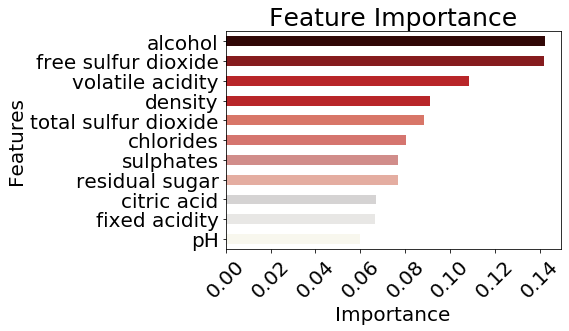

In [77]:
colors =  ["#F8F7EE","#E8E7E5","#D5D3D3","#E4ADA1","#D18D8A","#D5756F","#D87668","#B82629","#B82629","#861C1E", "#310706"] #["#F8F7F2", "#ECEBE6", "#DFDFDC","#D5D3D3","#B82629", "#310706", "#D5756F"] 
importances = pd.Series(rdf2.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color =iter(colors));
plt.xlabel('Importance', fontsize = 20)
plt.ylabel('Features',fontsize = 20 )
plt.xticks(fontsize = 20, rotation=45)
plt.yticks(fontsize = 20)
plt.title('Feature Importance', fontsize = 25)
plt.savefig("feature_importances.svg", format='svg', bbox_inches = 'tight')

In [78]:
rdf2.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight={0: 100, 1: 1.9, 2: 31},
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)>

In [79]:
#### Visualizing Decision Trees in Forest

In [80]:

# # Extract single tree
# estimator = rdf2

# from sklearn.tree import export_graphviz
# # Export as dot file
# export_graphviz(estimator, out_file='tree.dot', 
#                 feature_names = iris.feature_names,
#                 class_names = iris.target_names,
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# # Convert to png using system command (requires Graphviz)
# from subprocess import call
# call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'tree.png')

In [81]:
# import os
# from sklearn.tree import export_graphviz
# import six
# import pydot
# from sklearn import tree
# import random

# dotfile = six.StringIO()
# i_tree = 0

# index_forest = (random.randint(0,500), random.randint(0,500), random.randint(0,500))

# for i in index_forest:
#     tree_in_forest = rdf2.estimators_[i]
#     export_graphviz(tree_in_forest,out_file='tree.dot',
#     feature_names= list(X_train.columns),
#     class_names= ['poor', 'normal', 'excellent'],
#     filled=True,
#     rounded=True)
#     (graph,) = pydot.graph_from_dot_file('tree.dot')
#     name = 'tree' + str(i_tree)
#     graph.write_png(name+  '.png')
#     os.system('dot -Tpng tree.dot -o tree.png')
#     i_tree +=1

In [82]:
#zipped = zip(X_test, new_test_pred)
X_test['good_quality'] = new_test_pred
X_test

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,good_quality
3103,7.0,0.26,0.34,10.9,0.038,25.0,84.0,0.99432,3.11,0.34,10.9,0
1419,6.9,0.35,0.74,1.0,0.044,18.0,132.0,0.99200,3.13,0.55,10.2,0
4761,6.2,0.15,0.27,11.0,0.035,46.0,116.0,0.99602,3.12,0.38,9.1,1
4690,6.7,0.16,0.32,12.5,0.035,18.0,156.0,0.99666,2.88,0.36,9.0,1
4032,6.4,0.29,0.57,1.0,0.060,15.0,120.0,0.99240,3.06,0.41,9.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...
889,6.5,0.30,0.32,2.0,0.044,34.0,90.0,0.99185,3.37,0.68,11.0,2
2850,6.7,0.24,0.29,14.9,0.053,55.0,136.0,0.99839,3.03,0.52,9.0,1
4917,7.9,0.32,0.51,1.8,0.341,17.0,56.0,0.99690,3.04,1.08,9.2,1
5198,7.5,0.53,0.06,2.6,0.086,20.0,44.0,0.99650,3.38,0.59,10.7,1


In [83]:
poor_q = X_test[X_test['good_quality'] == 0]
normal_q = X_test[X_test['good_quality'] == 1]
excellent_q = X_test[X_test['good_quality'] == 2]


In [84]:
poor_q.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,good_quality
count,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.0
mean,7.288539,0.424914,0.269456,3.564900,0.057000,18.287966,97.661891,0.994314,3.223009,0.498682,10.394174,0.0
std,1.109305,0.190853,0.155406,3.296477,0.028348,13.815108,58.681064,0.002394,0.174319,0.100887,1.079295,0.0
min,4.700000,0.120000,0.000000,0.800000,0.013000,2.000000,8.000000,0.988680,2.720000,0.280000,8.600000,0.0
25%,6.600000,0.280000,0.160000,1.600000,0.040000,9.000000,54.000000,0.992800,3.100000,0.430000,9.500000,0.0
50%,7.100000,0.360000,0.280000,2.200000,0.050000,15.000000,95.000000,0.994240,3.220000,0.510000,10.100000,0.0
75%,7.900000,0.580000,0.350000,4.400000,0.071000,24.000000,129.000000,0.995930,3.340000,0.560000,11.100000,0.0
max,12.000000,1.115000,0.880000,19.800000,0.301000,131.000000,344.000000,1.001820,3.770000,1.060000,14.000000,0.0


In [85]:
normal_q.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,good_quality
count,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.00000,772.000000,772.0
mean,7.225907,0.306878,0.332060,6.448510,0.060582,35.242228,124.801166,0.995488,3.217111,0.53956,10.165846,1.0
std,1.248689,0.144491,0.141963,5.156784,0.045026,16.673087,55.696500,0.002839,0.155297,0.14770,0.951879,0.0
min,4.200000,0.080000,0.000000,0.700000,0.017000,4.000000,9.000000,0.988620,2.740000,0.28000,8.000000,1.0
25%,6.400000,0.210000,0.260000,1.975000,0.040000,24.000000,90.000000,0.993218,3.110000,0.44000,9.400000,1.0
50%,7.000000,0.260000,0.320000,4.900000,0.048000,35.000000,129.000000,0.995830,3.200000,0.51000,10.000000,1.0
75%,7.600000,0.360000,0.410000,10.450000,0.068250,47.000000,167.000000,0.997600,3.320000,0.62000,10.900000,1.0
max,14.000000,0.935000,1.000000,26.050000,0.610000,112.000000,253.000000,1.003690,3.800000,2.00000,13.000000,1.0


In [86]:
excellent_q.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,good_quality
count,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.0
mean,6.761453,0.309972,0.331397,4.308939,0.037855,31.248603,115.195531,0.991370,3.223743,0.517430,12.243147,2.0
std,1.309009,0.099436,0.110396,3.182122,0.015475,12.095404,35.975503,0.002179,0.157808,0.157027,0.873551,0.0
min,4.400000,0.080000,0.000000,0.800000,0.014000,3.000000,9.000000,0.987460,2.900000,0.230000,8.700000,2.0
25%,6.100000,0.240000,0.280000,2.000000,0.029000,23.500000,93.000000,0.989820,3.125000,0.390000,11.945000,2.0
50%,6.700000,0.300000,0.320000,3.000000,0.035000,31.000000,114.000000,0.991000,3.230000,0.490000,12.400000,2.0
75%,7.200000,0.350000,0.370000,6.150000,0.041000,37.000000,135.500000,0.992210,3.310000,0.605000,12.700000,2.0
max,15.900000,0.660000,0.740000,15.500000,0.132000,82.000000,289.000000,0.998600,3.690000,0.960000,14.900000,2.0


In [87]:
cm = confusion_matrix(y_test, new_test_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [88]:
sns.set_palette(sns.color_palette(colors))

In [89]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), 
                           labelsize=18, fontsize=15, numsize=20, cmap=None):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)#.tight_layout()
    fig.tight_layout()
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=".2g", annot_kws={"size": numsize}, cmap=colors)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.set_ylim(len(confusion_matrix),-0.5, -0.5)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=labelsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=labelsize)
    plt.ylabel('TRUE', fontsize=fontsize)
    plt.xlabel('PREDICTED', fontsize=fontsize)
    plt.title('Wine Quality Confusion Matrix', fontsize=fontsize + 5, loc='right')
    return fig;

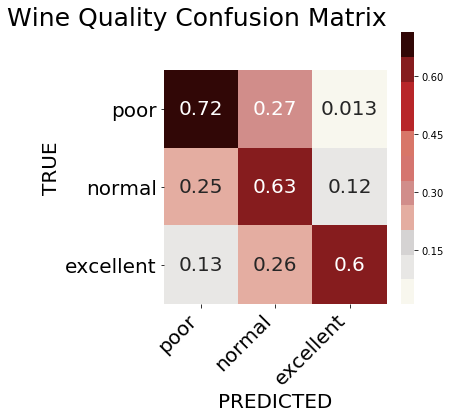

In [90]:
cm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
conf_m = print_confusion_matrix(cm_val, ['poor','normal','excellent'], figsize = (5,5), labelsize = 20, fontsize = 20, numsize= 20)

In [91]:
conf_m.savefig('final_result_perc.svg', format='svg',  bbox_inches='tight')

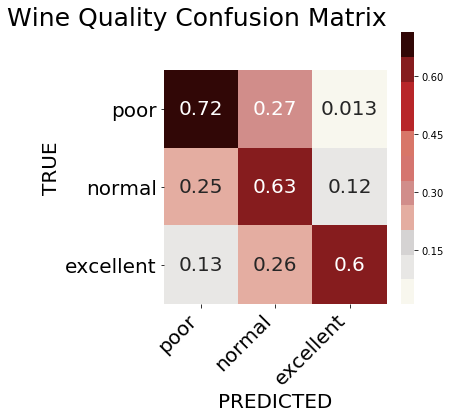

In [92]:
conf_m

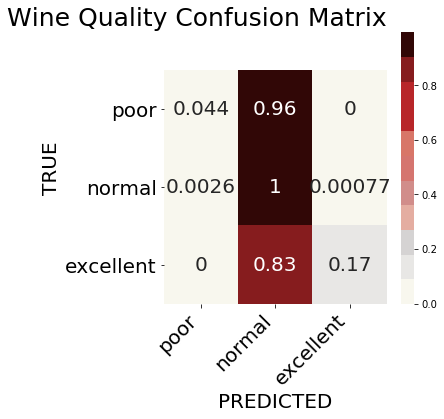

In [93]:
cm_baseline = cm_baseline.astype('float') / cm_baseline.sum(axis=1)[:, np.newaxis]
conf_baseline = print_confusion_matrix(cm_baseline, ['poor','normal','excellent'], figsize = (5,5), labelsize = 20, fontsize = 20, numsize= 20)
conf_baseline.savefig('baseline_result_perc.svg', format='svg',  bbox_inches='tight')